# <a id='preparation'></a> Подготовка

Все необходимые импорты вынесены в самый верх ноутбука. Использование других библиотек не запрещается, но крайне не рекомендуется

In [ ]:
import math
import time
import warnings
from functools import partial
from itertools import product
from typing import Callable, Iterator, Optional, List, Tuple

import cvxpy as cp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from tqdm import tqdm

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cpu')

## Построение графиков

Для удобства можете пользоваться следующей функцией для построения графиков

In [ ]:
def moving_average(x, w):
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


def draw_plots(
    data: dict,
    plots: list[tuple[dict, dict]],
    title: str = "",
    row_plots: int = 2,
    plot_width: float = 8,
    plot_height: float = 4,
    use_common_legend: bool = True,
):
    num_plots = len(plots)
    row_plots = min(row_plots, num_plots)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )
    if len(title):
        fig.suptitle(title, fontsize=14)
    axs_list = [axs] if num_plots == 1 else list(axs.flat)
    for ax in axs_list:
        ax.grid()
        ax.set_visible(False)

    for ax, (p1, p2) in zip(axs_list, plots):
        ax.set_visible(True)

        x_label = p1.get("axis_name", p1["name"])
        y_label = p2.get("axis_name", p2["name"])
        if p1.get("log", False):
            ax.set_xscale("log")
            x_label = f"{x_label}, log scale"
        if p2.get("log", False):
            ax.set_yscale("log")
            y_label = f"{y_label}, log scale"

        ax.set_title(f"{p2['name']} over {p1['name']}")
        ax.set(xlabel=x_label, ylabel=y_label)

        scatter_all = p1.get("scatter", False) or p2.get("scatter", False)

        for method, method_data in data.items():
            label = method

            x_values = method_data[p1.get("ref", p1["name"])]
            y_values = method_data[p2.get("ref", p2["name"])]

            y_smooth_w = p2.get("smooth", 0)
            if y_smooth_w:
                y_smooth = moving_average(y_values, w=y_smooth_w)
                ax.fill_between(
                    x_values,
                    scipy.ndimage.minimum_filter1d(y_smooth, y_smooth_w),
                    scipy.ndimage.maximum_filter1d(y_smooth, y_smooth_w),
                    alpha=0.1,
                )
                y_values = y_smooth

            ax.plot(x_values, y_values, label=label)
            ax_color = ax.get_lines()[-1].get_color()
            if scatter_all:
                ax.scatter(x_values, y_values, s=15, color=ax_color)
            else:
                ax.scatter(x_values[-1], y_values[-1], s=15, color=ax_color)

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, len(data)),
            bbox_to_anchor=(0.5, -0.05 * (math.ceil(len(data) / 6) + 1)),
        )
    else:
        if len(data) > 1:
            for ax in axs_list:
                ax.legend()

    plt.tight_layout()
    plt.show()

## [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

Датасет понадобится для выполнения некоторых заданий Дней 3 и 5

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
len(train_mnsit_seq)=2850, len(test_mnsit_seq)=150


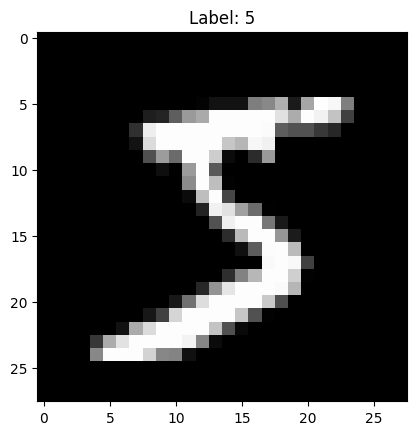

In [ ]:
# скачиваем MNIST
MNIST(root="data/", download=True)
mnist_dataset = MNIST(root="data/", train=True, transform=transforms.ToTensor())
print(mnist_dataset)

# выведем первое изображение
image, label = mnist_dataset[0]
plt.imshow(image.reshape(28, 28), cmap="gray")
plt.title(
    f"Label: {label}",
)

# будем использовать только часть данных
mnist_ratio = 0.05

# делим данные на test и train
train_mnsit_seq, test_mnsit_seq, _ = random_split(
    mnist_dataset,
    [0.95 * mnist_ratio, 0.05 * mnist_ratio, 1 - mnist_ratio],
    generator=torch.Generator().manual_seed(420),
)
print(f"{len(train_mnsit_seq)=}, {len(test_mnsit_seq)=}")

mnist_train_loader = DataLoader(train_mnsit_seq, 64, shuffle=True)
mnist_test_loader = DataLoader(test_mnsit_seq, 512, shuffle=False)

Создадим простую модель для экспериментов

In [ ]:
class MnistModel(nn.Module):
    def __init__(self, input_dim: int = 28 * 28, output_dim: int = 10):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.net(x)

Полезные функции для тренировки и оценки на датасете MNIST

In [ ]:
def train_mnist(
    model: nn.Module, optimizer: torch.optim.Optimizer, **loss_kwargs
) -> None:
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for inputs, labels in mnist_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward(**loss_kwargs)
        optimizer.step()


def eval_mnist(model: nn.Module) -> tuple[float, float]:
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        model.eval()
        for inputs, labels in mnist_test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss += loss_fn(outputs, labels).item()
    return val_loss, correct / total

## [CIFAR-10](https://paperswithcode.com/dataset/cifar-10)

Датасет понадобится для выполнения некоторых заданий Дня 4

Files already downloaded and verified
Files already downloaded and verified
len(cifar_train_dataset)=2500
len(cifar_test_dataset)=500


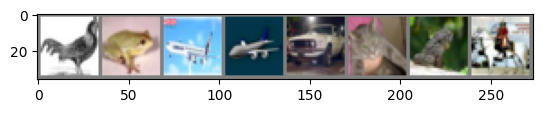

bird  frog  plane plane car   cat   frog  horse


In [ ]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# загружаем датасет
cifar_train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=cifar_transform
)
cifar_test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=cifar_transform
)

# будем использовать только часть данных
cifar_ratio = 0.05

# делим данные train и test
cifar_train_dataset, _ = random_split(
    cifar_train_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)
cifar_test_dataset, _ = random_split(
    cifar_test_dataset,
    [cifar_ratio, 1 - cifar_ratio],
    generator=torch.Generator().manual_seed(420),
)

print(f"{len(cifar_train_dataset)=}")
print(f"{len(cifar_test_dataset)=}")

assert len(cifar_train_dataset) == 2500
assert len(cifar_test_dataset) == 500

cifar_train_loader = torch.utils.data.DataLoader(
    cifar_test_dataset, batch_size=64, shuffle=True
)

cifar_test_loader = torch.utils.data.DataLoader(
    cifar_test_dataset, batch_size=256, shuffle=False
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


def imshow(image):
    image = image / 2 + 0.5  # де-нормализуем
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    plt.show()


# несколько случайных элементов
images, labels = next(iter(cifar_train_loader))
images, labels = images[:8], labels[:8]

# выведем изображения
imshow(torchvision.utils.make_grid(images))

# выведем метки
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

In [ ]:
class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Создадим сложную модель ([ResNet](https://arxiv.org/abs/1512.03385)) для экспериментов

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)

In [ ]:
def train_cifar(
    model: nn.Module, optimizer: torch.optim.Optimizer, **loss_kwargs
) -> None:
    loss_fn = nn.CrossEntropyLoss()
    model.train()
    for inputs, labels in cifar_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, labels)
        loss.backward(**loss_kwargs)
        optimizer.step()


def eval_cifar(model: nn.Module) -> tuple[float, float]:
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for inputs, labels in cifar_test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            val_loss += loss_fn(outputs, labels).item()
    return val_loss, correct / total

## Часть 1. Матрично-векторное дифференцирование
Тут все прорешано, но полезно посмотреть, как это делается руками

### Задание 1

Вычислите градиенты $\nabla_A L, \nabla_b L$ функции ошибки $L$ для входных параметров $A,b$ соответсвенно. Градиент от параметра $x$ считается известным и равным $\nabla_x L$. Рекомендуется использовать алгоритм обратного распространения ошибки (backpropagation algorithm)

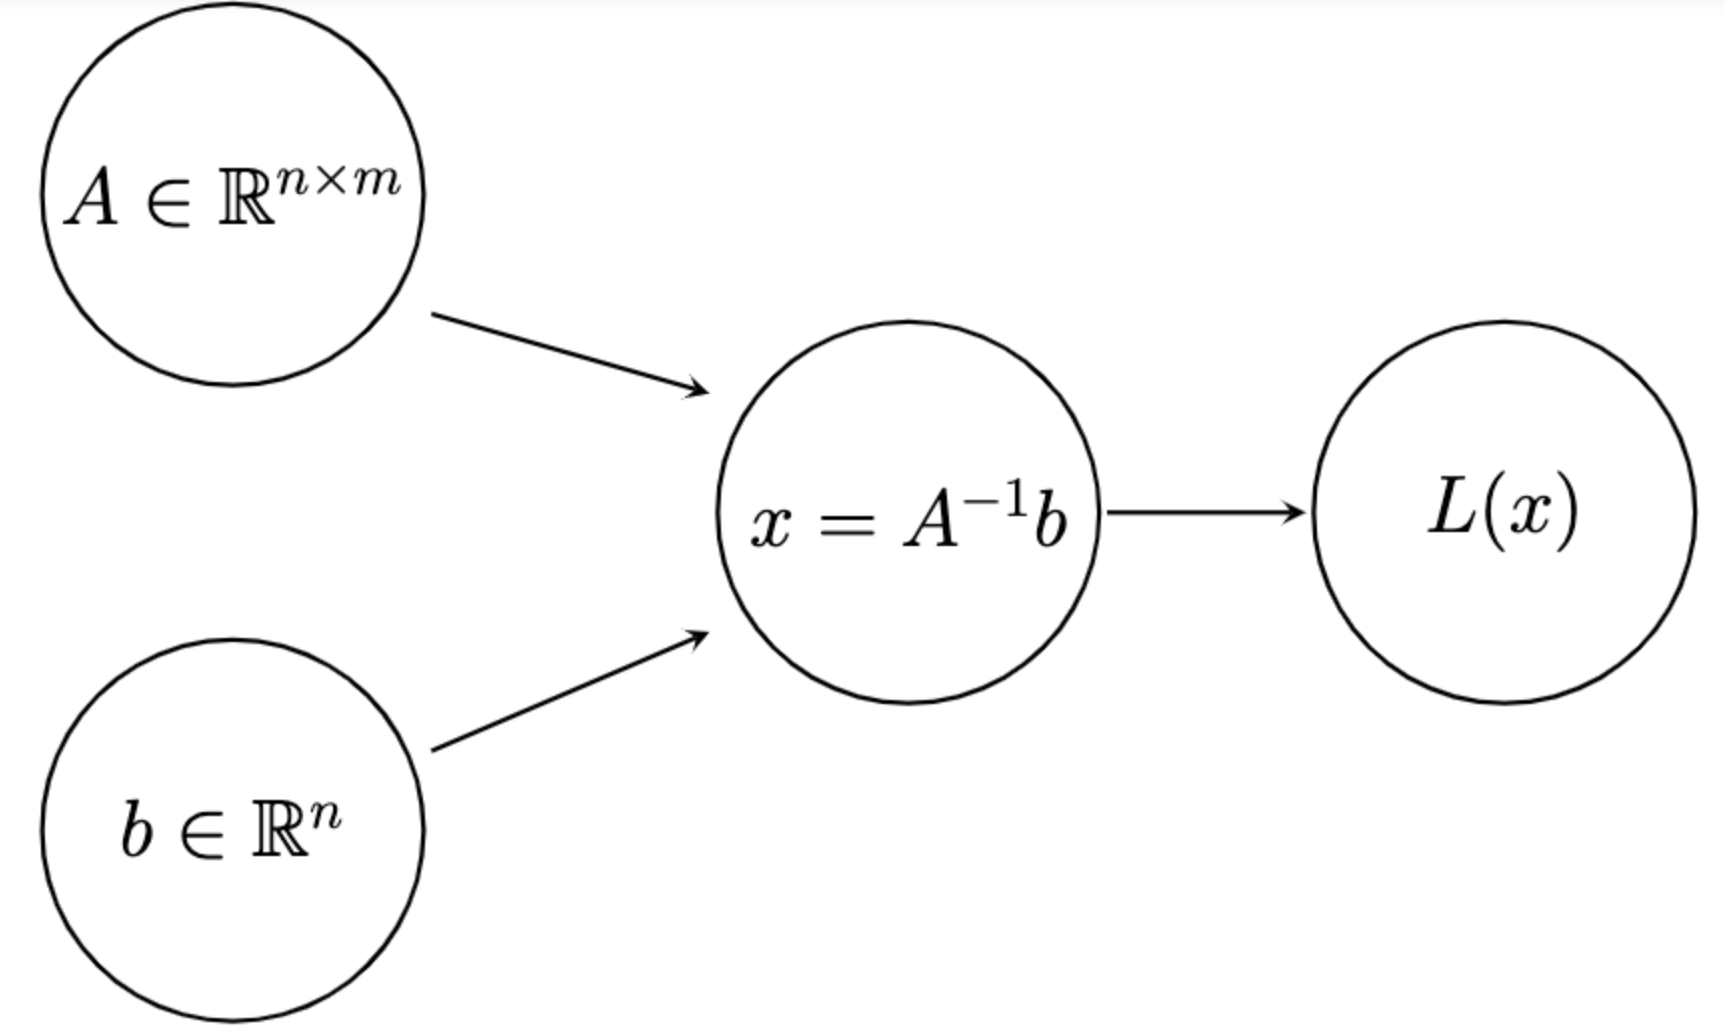



### Решение

* $$
\begin{gathered}
\nabla_b L = \nabla_x L = \frac{∂x}{∂b} \\
\frac{∂x}{∂b} = A^{-1} \\
∇_b L = ∇_x L \cdot A^{-1}
\end{gathered}
$$

* $$
\begin{gathered}
∇_A L = ∇_x L \frac{∂x}{∂A} \quad\quad \left( \frac{∂A^{-1}}{∂A} = -A^{-1}\frac{∂A}{∂A} A^{-1} \right) \\
\frac{\partial x}{\partial A} = \frac{\partial (A^{-1} b)}{\partial A} = \frac{\partial A^{-1}}{\partial A}b + A^{-1} \frac{\partial b}{\partial A} = \\
= \frac{\partial A^{-1}}{\partial A} b = -A^{-1} \frac{\partial A}{∂ A} A^{-1} b = -A^{-1} A^{-1} b \\
∇_A L = -∇_x L \cdot A^{-1} A^{-1} b
\end{gathered}
$$

### Задание 2

Вычислите производную первого порядка для следующей функции $f : \mathbb{R}^d \setminus \{ 0 \} \to \mathbb{R}$ такой, что $\displaystyle f(x) = \langle x, x \rangle^{\langle x, x \rangle}$

### Решение

$$
\begin{gathered}
f(x) = y = \langle x, x \rangle^{\langle x, x \rangle} \\
\log y =\langle x, x \rangle \log{\langle x, x \rangle} \\
\frac{1}{y}\frac{dy}{dx} = \frac{d \langle x, x \rangle}{dx} \log{\langle x, x \rangle} + \langle x, x \rangle \frac{d\log{\langle x, x \rangle}}{dx} = \\
= 2 x \log\langle x, x \rangle + \langle x, x \rangle \frac{1}{\langle x, x \rangle} \frac{d \langle x, x \rangle}{dx} = \\
= 2x \log \langle x, x \rangle + 2x = \frac{1}{y} \frac{dy}{dx} \\
\frac{dy}{dx} = 2x ( \log \langle x, x \rangle + 1) \langle x, x \rangle ^ {\langle x, x \rangle}
\end{gathered}
$$

### Задание 3*

Вычислите производную **второго** порядка для функции из предыдущего задания $f : \mathbb{R}^d \setminus \{ 0 \} \to \mathbb{R}$ такой, что $\displaystyle f(x) = \langle x, x \rangle^{\langle x, x \rangle}$

### Решение

Вычисление $\frac{d(\langle x, x \rangle^{\langle x, x \rangle})}{dx}$ было в прошлом шаге, переносить сюда не буду, и так длинно выходит

$$\begin{gathered}
\frac{d^2 y}{dx^2} = \frac{d ( 2x ( \log \langle x, x \rangle + 1) \langle x, x \rangle ^ {\langle x, x \rangle} ) }{dx} = \\
= \frac{d (2x (\log\langle x, x \rangle +1)}{dx}\langle x, x \rangle ^{\langle x, x \rangle} + 2x ( \log \langle x, x \rangle + 1) \frac{d(\langle x, x \rangle^{\langle x, x \rangle})}{dx} = \\
= \left( 2(\log\langle x, x \rangle +1) + \frac{2x \ d \langle x, x \rangle}{\langle x, x \rangle dx} \right)\langle x, x \rangle^{\langle x, x \rangle} +
2x ( \log \langle x, x \rangle + 1) \frac{d(\langle x, x \rangle^{\langle x, x \rangle})}{dx} = \\
= \left(2( \log \langle x, x \rangle + 1) + \frac{4x}{\langle x,x\rangle} \right) \langle x, x \rangle ^ {\langle x, x \rangle} + 2x ( \log \langle x, x \rangle + 1) \frac{d(\langle x, x \rangle^{\langle x, x \rangle})}{dx}
\end{gathered}
$$

## Часть 2*. Выпуклость

### Задание 1

Проверьте, что множество $S = \{ x_1 \in \mathbb{R}, x_2 \in \mathbb{R} \mid x_1 > 0, x_2 > 0, x_1 x_2 \geq 1 \}$ является выпуклым

### Решение

Нужно доказать, что для любых двух точек $A = (x_1^A, x_2^A)$ и $B = (x_1^B, x_2^B)$ из $S$, любая их выпуклая комбинация также принадлежит $S$. То есть для любой точки $C = \lambda A + (1-\lambda) B$, где $\lambda \in [0, 1]$, $C$ должна принадлежать $S$.

Пусть $ A = (x_1^A, x_2^A) $ и $ B = (x_1^B, x_2^B) $ принадлежат $ S $. Это означает, что:

$ x_1^A > 0, \quad x_2^A > 0, \quad x_1^A x_2^A \geq 1 $

$ x_1^B > 0, \quad x_2^B > 0, \quad x_1^B x_2^B \geq 1 $ из условия

Пусть $ C = (\lambda x_1^A + (1-\lambda) x_1^B, \lambda x_2^A + (1-\lambda) x_2^B) $, где $ \lambda \in [0, 1] $. Нам надо доказать, что $ C \in S $, то есть
$ (\lambda x_1^A + (1-\lambda) x_1^B)(\lambda x_2^A + (1-\lambda) x_2^B) \geq 1 $

Используем неравенство Коши-Буняковского:
$
(\lambda x_1^A + (1-\lambda) x_1^B)(\lambda x_2^A + (1-\lambda) x_2^B) \geq \lambda^2 x_1^A x_2^A + 2\lambda(1-\lambda) \sqrt{x_1^A x_2^A \cdot x_1^B x_2^B} + (1-\lambda)^2 x_1^B x_2^B.
$

Так как $x_1^A x_2^A \geq 1$ и $x_1^B x_2^B \geq 1$, мы имеем $\sqrt{x_1^A x_2^A \cdot x_1^B x_2^B} \geq 1$. Таким образом:
$
\lambda^2 x_1^A x_2^A + 2\lambda(1-\lambda) \sqrt{x_1^A x_2^A \cdot x_1^B x_2^B} + (1-\lambda)^2 x_1^B x_2^B \geq \lambda^2 + 2\lambda(1-\lambda) + (1-\lambda)^2.
$

Поскольку $\lambda^2 + 2\lambda(1-\lambda) + (1-\lambda)^2 = (\lambda + (1-\lambda))^2 = 1$, то:
$
\lambda^2 x_1^A x_2^A + 2\lambda(1-\lambda) \sqrt{x_1^A x_2^A \cdot x_1^B x_2^B} + (1-\lambda)^2 x_1^B x_2^B \geq 1.
$

Следовательно,
$
(\lambda x_1^A + (1-\lambda) x_1^B)(\lambda x_2^A + (1-\lambda) x_2^B) \geq 1,
$
что доказывает, что любая выпуклая комбинация точек из $S$ также принадлежит $S$. Отсюда множество $S$ является выпуклым.

### Задание 4

**Подсказка:** Возможно в этом задании (и возможно не только в нём) вам понадобятся следующие факты:

- дифференцируемая функция является выпуклой тогда и только тогда, когда

  $$
  \nabla^2 f(x) \geq 0 \quad \text{(Гессиан положительно полуопределён)}.
  $$

- дифференцируемая функция является $\mu$-сильно выпуклой тогда и только тогда, когда
  $$
  \nabla^2 f(x) \geq \mu I.
  $$

Проверьте, что функция $f: \mathbb{R}^2 \to \mathbb{R}$ такая, что $f(x) = x_1^2 x_2^2$, является выпуклой

### Решение

$$
\frac{\partial f}{\partial x_1} = 2x_1 x_2^2 \\
\frac{\partial f}{\partial x_2} = 2x_1^2 x_2 \\\\
\frac{\partial^2 f}{\partial x_1^2} = \frac{\partial}{\partial x_1} (2x_1 x_2^2) = 2 x_2^2 \\
\frac{\partial^2 f}{\partial x_2^2} = \frac{\partial}{\partial x_2} (2x_1^2 x_2) = 2 x_1^2 \\
\frac{\partial^2 f}{\partial x_1 \partial x_2} = \frac{\partial}{\partial x_2} (2x_1 x_2^2) = 4x_1 x_2 \\
\nabla^2 f(x) = \begin{pmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} \\
\frac{\partial^2 f}{\partial x_1 \partial x_2} & \frac{\partial^2 f}{\partial x_2^2}
\end{pmatrix} = \begin{pmatrix}
2x_2^2   & 4x_1 x_2 \\
4x_1 x_2 & 2x_1^2
\end{pmatrix}
$$

Матрица 2x2 положительно полуопределена, если все ее главные миноры неотрицательны.
- $2x_2^2 \geq 0$
- $\det(\nabla^2 f(x)) = (2x_2^2)(2x_1^2) - (4x_1 x_2)^2 = 4x_1^2 x_2^2 - 16x_1^2 x_2^2 = -12x_1^2 x_2^2$

# <a id='day2'></a> День 2

## Часть 1. Задача безусловной оптимизации

Рассмотрим проблему минимизации эмпирического риска (empirical risk minimization, ERM)
$$
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w \|^2_2,
\end{equation}
$$
где $\ell$ - функция ошибки, $g$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ набор данных состоящий из признаков $x_i$ и значений $y_i$, $\lambda > 0$ - параметр регуляризации

Будем использовать линейную модель $g(w, x) = w^T x$ и логистическую (сигмоидальную) функцию ошибки: $\ell(z,y) = \ln (1 + \exp(-yz))$ (**Важно: $y$ должны принимать значения -1 или +1**). Получившуюся задачу обычно называют задачей логистической регрессией

### Задание 1

В этом задании вам нужно:

- Вычислить градиент и Гессиан для данной задачи
- Доказать, что задача является $\mu$-сильно выпуклой и имеет $L$-Липшецевый градиент с $\mu = \lambda$ и $L = \lambda + \frac{1}{4n} \sum_{i=1}^n \| x_i\|^2_2$

### Решение

Перепишем функцию в вид $\ell(w^T x_i, y_i) = \ln(1 + \exp(-y_i w^T x_i))$ и обозначим $\sigma(z) = \frac{1}{1 + \exp(-z)}$
### Градиент
- $\sigma'(-y_i w^T x_i) = \sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i))$
- $\nabla_w \ell(w^T x_i, y_i) = \frac{\partial}{\partial w} \ln(1 + \exp(-y_i w^T x_i)) = -y_i x_i \sigma(-y_i w^T x_i)$
- $\nabla_w \frac{1}{n} \sum\limits_{i=1}^n \ell (w^T x_i, y_i) = -\frac{1}{n} \sum_{i=1}^n y_i x_i \sigma(-y_i w^T x_i)$
- $\nabla_w \left( \frac{1}{n} \sum_{i=1}^n \ell (w^T x_i, y_i) + \frac{\lambda}{2} \| w \|^2_2 \right) = -\frac{1}{n} \sum_{i=1}^n y_i x_i \sigma(-y_i w^T x_i) + \lambda w$

### Гессиан
- $\nabla_w^2 \ell(w^T x_i, y_i) = x_i x_i^T \sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i))$
- $\nabla_w^2 \frac{1}{n} \sum_{i=1}^n \ell (w^T x_i, y_i) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T \sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i))$
- $\nabla_w^2 \left( \frac{1}{n} \sum_{i=1}^n \ell (w^T x_i, y_i) + \frac{\lambda}{2} \| w \|^2_2 \right) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T \sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i)) + \lambda I$

### $\mu$ - сильная выпуклость
$$
\nabla^2 f(x) \geq \mu I \\
\nabla^2 f(x) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T \sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i)) + \lambda I \\
\sigma(-y_i w^T x_i) (1 - \sigma(-y_i w^T x_i)) \in [0, \frac14]
$$
собств. значения штуки сверху неотриц., $+\lambda I$ добавляет $\lambda$ к собств. значениям всего выражения

### $L$ - Липшицевость градиента

По определению $\| \nabla f(w) - \nabla f(v) \| \leq L \| w - v \|$.

- $\nabla_w L(w) - \nabla_w L(w') = \frac{1}{n} \sum_{i=1}^n \left( \sigma(-y_i w^T x_i) y_i x_i - \sigma(-y_i {w'}^T x_i) y_i x_i \right) + \lambda (w - w') = \frac{1}{n} \sum_{i=1}^n y_i x_i \left( \sigma(-y_i w^T x_i) - \sigma(-y_i {w'}^T x_i) \right) + \lambda (w - w').$
- $|\sigma(-y_i w^T x_i) - \sigma(-y_i {w'}^T x_i)| \leq \frac{1}{4} |y_i x_i^T (w - w')|$
- $\|\nabla_w L(w) - \|\nabla_w L(w')\| \leq \frac{1}{n} \sum_{i=1}^n \frac{1}{4} \|y_i x_i^T (w - w')\| + \lambda \|w - w'\| = \\ =  \frac{1}{n} \sum_{i=1}^n \frac{1}{4} \|x_i^T (w - w')\| + \lambda \|w - w'\| \leq \\ \leq \frac{1}{4n} \sum_{i=1}^n \|x_i\|^2 \|w - w'\| + \lambda \|w - w'\| \leq \\ \leq \left(\lambda + \frac{1}{4n} \sum_{i=1}^n \|x_i\|^2\right) \|w - w'\| $

Итого

$$L = \lambda + \frac{1}{4n} \sum_{i=1}^n \|x_i\|^2$$

### Задание 2 (здесь начинается условие дз)

К ноутбуку прилагается датасет *mushrooms.txt*. Так же его можно скачать по [ссылке](https://drive.google.com/file/d/1lgwawQxGD_6XruWbquMH6W2yKPVQ5kdi/view?usp=sharing)

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1lgwawQxGD_6XruWbquMH6W2yKPVQ5kdi/view -O mushrooms.txt

Downloading...
From: https://drive.google.com/uc?id=1lgwawQxGD_6XruWbquMH6W2yKPVQ5kdi
To: /content/mushrooms.txt
100% 880k/880k [00:00<00:00, 117MB/s]


In [ ]:
# файл должен лежать в той же директории, что и ноутбук
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
mushrooms_x, mushrooms_y = data[0].toarray(), data[1]

# сделаем y -1 или 1
mushrooms_y = 2 * mushrooms_y - 3

train_mush_x, test_mush_x, train_mush_y, test_mush_y = train_test_split(
    mushrooms_x, mushrooms_y, test_size=0.2, random_state=42
)

print(f"{train_mush_x.shape=}")
print(f"{train_mush_y.shape=}")

train_mush = list(zip(train_mush_x, train_mush_y))
test_mush = list(zip(test_mush_x, test_mush_y))

print(f"{len(train_mush)=}")
print(f"{len(test_mush)=}")

assert len(train_mush) == 6499
assert len(test_mush) == 1625

train_mush_x.shape=(6499, 112)
train_mush_y.shape=(6499,)
len(train_mush)=6499
len(test_mush)=1625


В этом задании вам нужно:
- Для тренировочной части `train_mush` оценить константу $L =  \frac{1}{4n} \sum\limits_{i=1}^n \| x_{i} \|^2_2 + \lambda$.
Возьмите $\lambda \approx L / 1000$
- Написать функцию для вычисления значения $f(w)$, градиента $\nabla f(w)$ и гессиана $\nabla^2 f(w)$. Функции должны принимать также параметры $x$ и $y$ (`train_mush_x`, `train_mush_y`)
- Проверить правильность функции для вычисления $f(w)$, используя функцию `assert_mush()`. Если проверка не проведена или провалена, **задание автоматически считается невыполненным**
- Написать функцию `mush_accuracy()`, которая бы считала точность предсказаний на тестовых данных `test_mush`

In [ ]:
def assert_mush(mush_f: Callable, mush_grad: Callable, mush_hess: Callable):
    w = np.zeros(train_mush_x[0].shape[0])
    assert np.isclose(mush_f(w), 0.6931471805599453)
    assert np.isclose(mush_grad(w).sum(), -0.3732112632712724)
    assert np.isclose(mush_hess(w).sum(), 110.83858858858859)

### Решение

In [ ]:
n = train_mush_x.shape[0]
L_unregularized = np.sum(np.linalg.norm(train_mush_x, axis=1)**2) / (4 * n)
lambda_ = L_unregularized / 1000
L = L_unregularized + lambda_

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def mush_f(w, x=train_mush_x, y=train_mush_y, lambda_=lambda_):
    n = x.shape[0]
    z = y * (x @ w)
    log_likelihood = np.log(1 + np.exp(-z))
    return np.mean(log_likelihood) + 0.5 * lambda_ * np.dot(w, w)

def mush_grad(w, x=train_mush_x, y=train_mush_y, lambda_=lambda_):
    n = x.shape[0]
    z = y * (x @ w)
    grad = -(y * sigmoid(-z)) @ x / n
    return grad + lambda_ * w

def mush_hess(w, x=train_mush_x, y=train_mush_y, lambda_=lambda_):
    n = x.shape[0]
    z = y * (x @ w)
    s = sigmoid(-z) * sigmoid(z)
    S = np.diag(s)
    hessian = (x.T @ S @ x) / n
    return hessian + lambda_ * np.eye(x.shape[1])

In [ ]:
def mush_accuracy(w, x=test_mush_x, y=test_mush_y):
    preds = sigmoid(x @ w)
    preds = np.where(preds >= 0.5, 1, -1)
    accuracy = np.mean(preds == y)
    return accuracy

Проверка

In [ ]:
assert_mush(mush_f, mush_grad, mush_hess)

### Задание 3 (начиная отсюда надо решать!) (5 баллов)

Рассмотрим метод градиентного спуска (Gradient Descent)

$$
\begin{equation*}
x_{k+1} = x_k - \gamma_k \nabla f(x_k)
\end{equation*}
$$

В этом задании вам нужно:
- Дописать функцию `check_approx_mush`, которая будет использоваться для тестирования алгоритмов на датасете mushrooms. В качестве критерия сходимости рекомендуется использовать норму градиента, но вы можете использовать любой другой критерий
- Реализовать градиентный спуск как класс, унаследованный от `ManualSolver` (определён ниже)
- Запустить градиентный спуск на датасете mushrooms на 500 эпохах и $\gamma_k=0.001$
- Построить следующие графики (можете использовать для этого функцию `draw_plots()`):
  - Критерий / Эпоха
  - Критерий / Эпоха (логарифмическая шкала)

### Решение

In [ ]:
w_mush_shape = train_mush_x.shape[1]
np.random.seed(420)
start_w_mush = np.random.randn(w_mush_shape)  # начальная точка для всех экспериментов

In [ ]:
class BaseSolver:
    def step(self, x: np.ndarray, k: int) -> np.ndarray:
        # эту функцию должны переопределить наследуемые классы
        raise NotImplementedError


class ManualSolver(BaseSolver):
    def __init__(
        self,
        lr: float | Callable,
        grad_f: Callable = mush_grad,
        hess_f: Callable = mush_hess,
    ) -> None:
        self.grad_f = grad_f
        self.hess_f = hess_f
        self.lr = lr if isinstance(lr, Callable) else lambda _: lr

In [ ]:
def check_approx_mush(
    approximations: list[tuple[str, BaseSolver]],
    epochs: int = 500,
    start_w: np.ndarray = start_w_mush,
    stop_criterion: float = 1e-5,
) -> dict:
    results_dict = {}

    for name, approx in approximations:
        accuracies = []
        criterion_logs = []  # нормы градиента или что-то другое
        time_logs = []

        np.random.seed(420)
        w = start_w.copy()

        # initial eval
        ... #TODO

        # log
        ... #TODO

        start_time = time.time()

        with tqdm(range(epochs), desc=name) as loop:
            for k in loop:
                # train
                w = approx.step(w, k)

                # eval
                ... #TODO

                # Остановить, если результат функции не определён
                if np.isnan(...) or np.isinf(...): #
                    break

                # log
                ... #TODO

                time_logs.append(time.time() - start_time)
                loop.set_postfix({"Loss": ..., "Accuracy": ..., "Grad norm": ...}) # TODO

                # Остановить, если criterion <= stop_criterion
                ... #TODO

        results_dict[name] = {
            "Epoch": list(range(len(accuracies))),
            "Time": time_logs,
            "Accuracy": accuracies,
            "Criterion": criterion_logs,
            "W": w.copy(),
        }

    return results_dict

Gradient Descent: 100%|██████████| 500/500 [00:06<00:00, 80.03it/s, Loss=1.21, Accuracy=0.668, Grad norm=0.93]


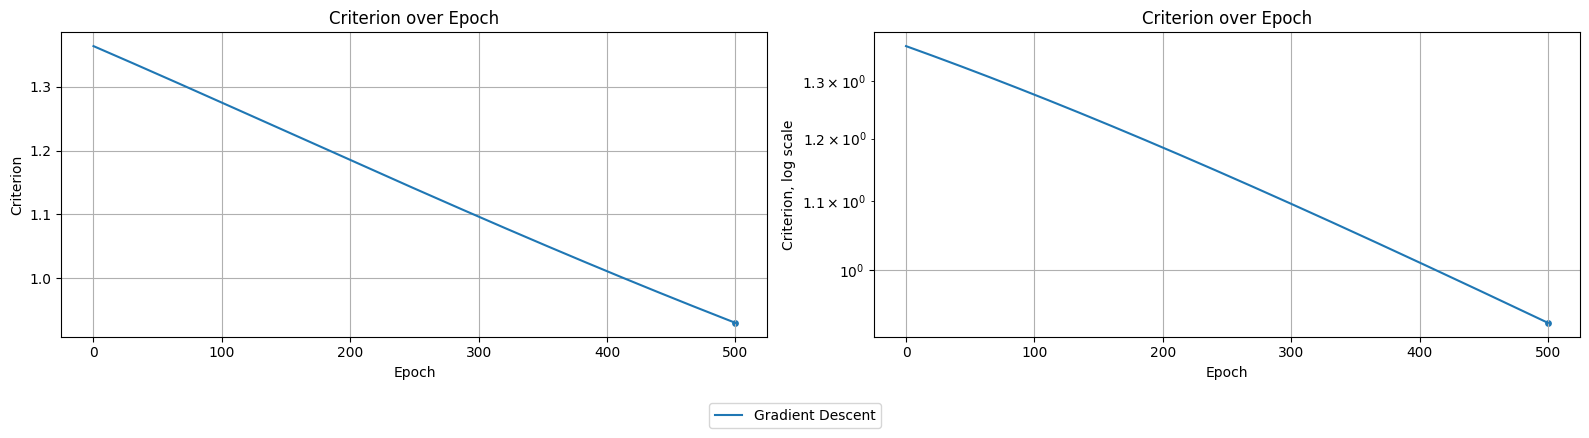

In [ ]:
w_mush_shape = train_mush_x.shape[1]
np.random.seed(420)
start_w_mush = np.random.randn(w_mush_shape)

gd_solver = GradientDescent(lr=0.001)

results = check_approx_mush([("Gradient Descent", gd_solver)], epochs=500, start_w=start_w_mush, stop_criterion=1e-5)

plot_criterion_epoch = partial(
    draw_plots,
    plots=[
        ({"name": "Epoch"}, {"name": "Criterion"}),
        ({"name": "Epoch"}, {"name": "Criterion", "log": True})
    ],
)

plot_criterion_epoch(results)

### Задание 4 (3 балла)

В этом задании вам нужно:
- Протестировать градиентный спуск с шагом $\gamma_k = \frac{1}{L}$ на 500 эпохах
- Протестировать градиентный спуск с разными, но константными шагами $\gamma_k = \gamma$ на 1000 эпохах (не менее четырёх экспериментов). Попробуйте $\gamma$ из диапазона от $0$ до $3/L$
- Построить следующие графики (в дальнейших заданиях нужно использовать такой же набор графиков):
  - Критерий / Эпоха (логарифмическая шкала)
  - Критерий / Время (логарифмическая шкала)
  - Точность (Accuracy) / Эпоха
  - Точность (Accuracy) / Время

- Определить, какой шаг оказался "лучшим". Не забудьте пояснить, по каким критериям определяли "лучший"
- Сделайте выводы

### Решение

Gradient Descent 1/L: 100%|██████████| 500/500 [00:06<00:00, 72.49it/s, Loss=0.195, Accuracy=0.977, Grad norm=0.0336]


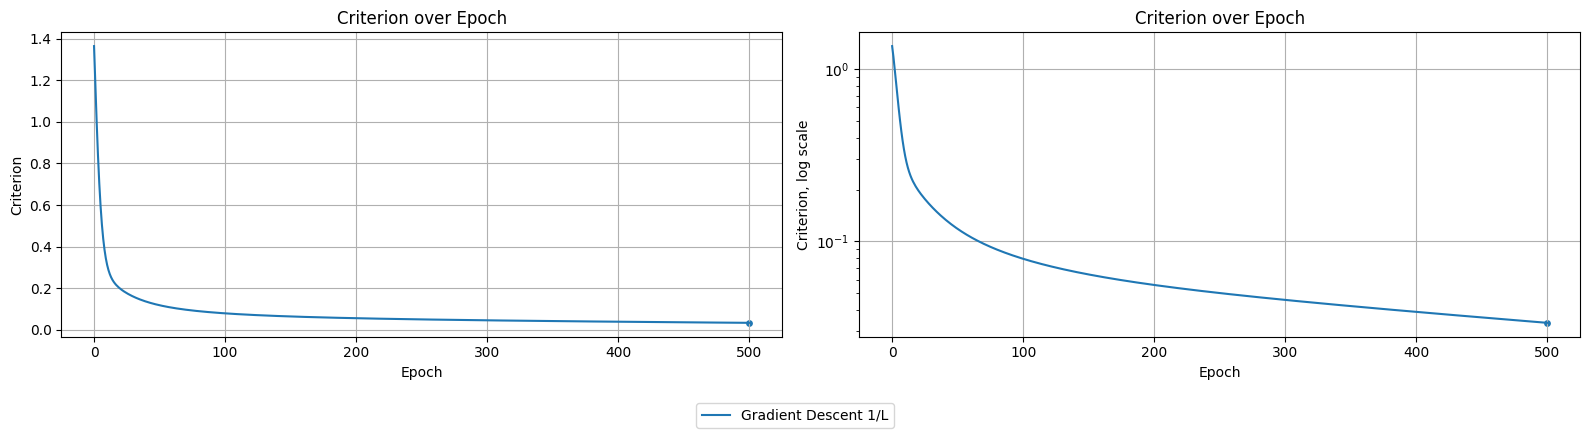

In [ ]:
gamma_L

0.19028590457161884

GD gamma=$3 / L$: 100%|██████████| 1000/1000 [00:13<00:00, 75.85it/s, Loss=0.113, Accuracy=0.989, Grad norm=0.00183]


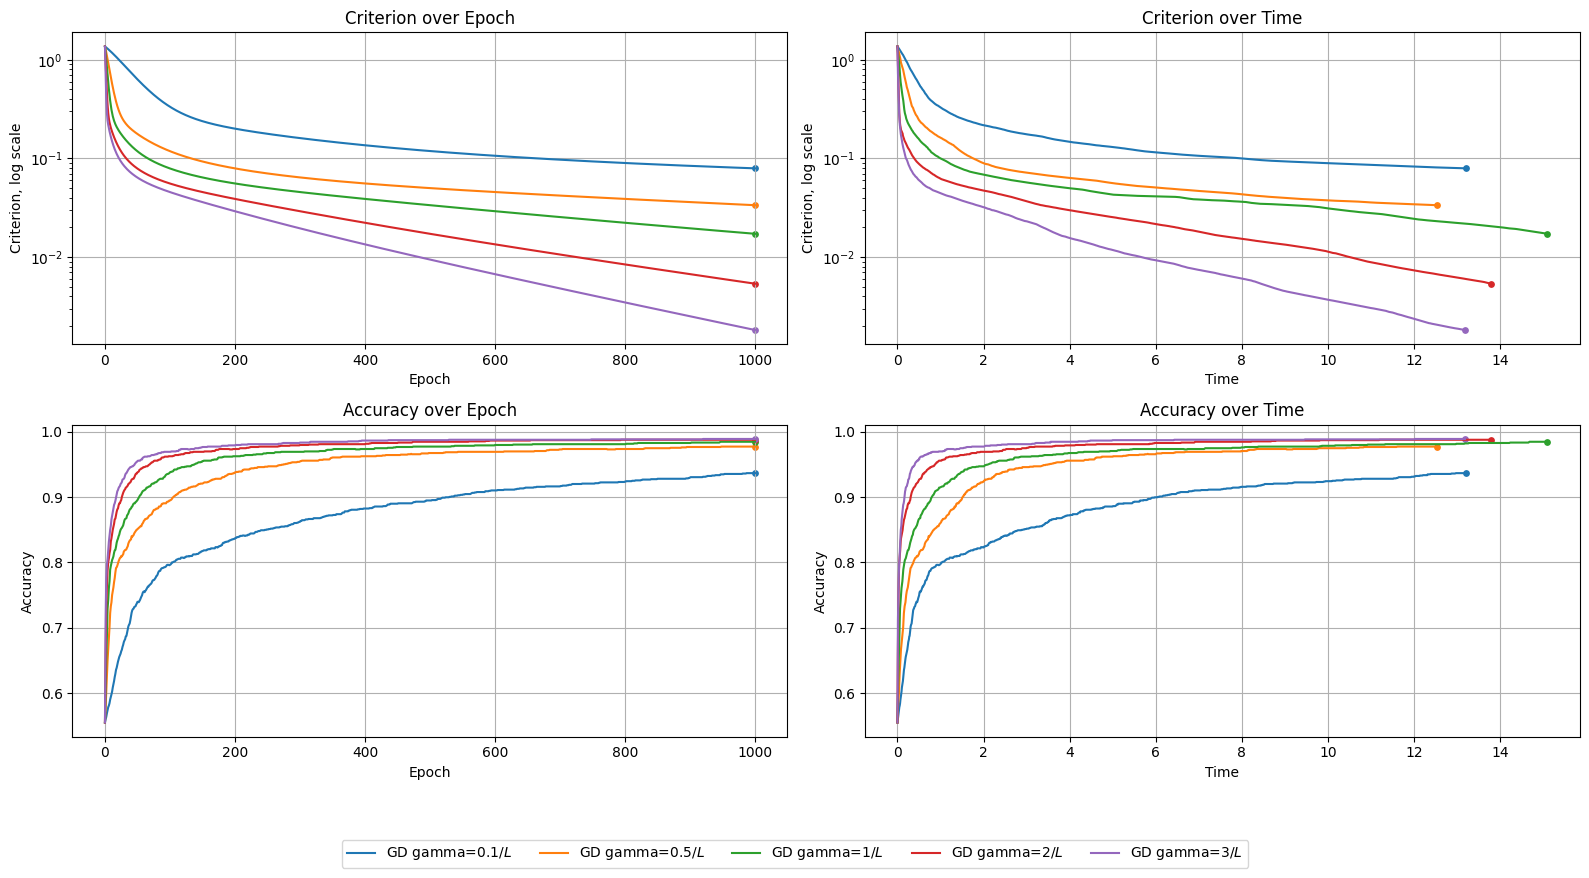

**Выводы**

### Задание 5* (3 балла)

Теперь рассмотрим другие техники выбора шага, а не только константные

В этом задании вам нужно:
- Протестировать градиентный спуск с шагом $\gamma_k = \frac{\gamma}{\delta + k}$, где  $\gamma$ и $\delta$ должны быть подобраны по-отдельности. Какая конфигурация показывает лучшие результаты?
- Протестировать градиентный спуск с шагом $\gamma_k = \frac{\gamma}{\delta + \sqrt{k}}$, где  $\gamma$ и $\delta$ должны быть подобраны по-отдельности. Какая конфигурация показывает лучшие результаты?
- Построить сравнительные графики на датасете mushrooms для предложенных подходов (в том числе из предыдущих заданий)
- Сделайте выводы


### Решение

GD decay gamma=10.5105, delta=0.5: 100%|██████████| 1000/1000 [00:13<00:00, 74.99it/s, Loss=0.561, Accuracy=0.967, Grad norm=0.0826]


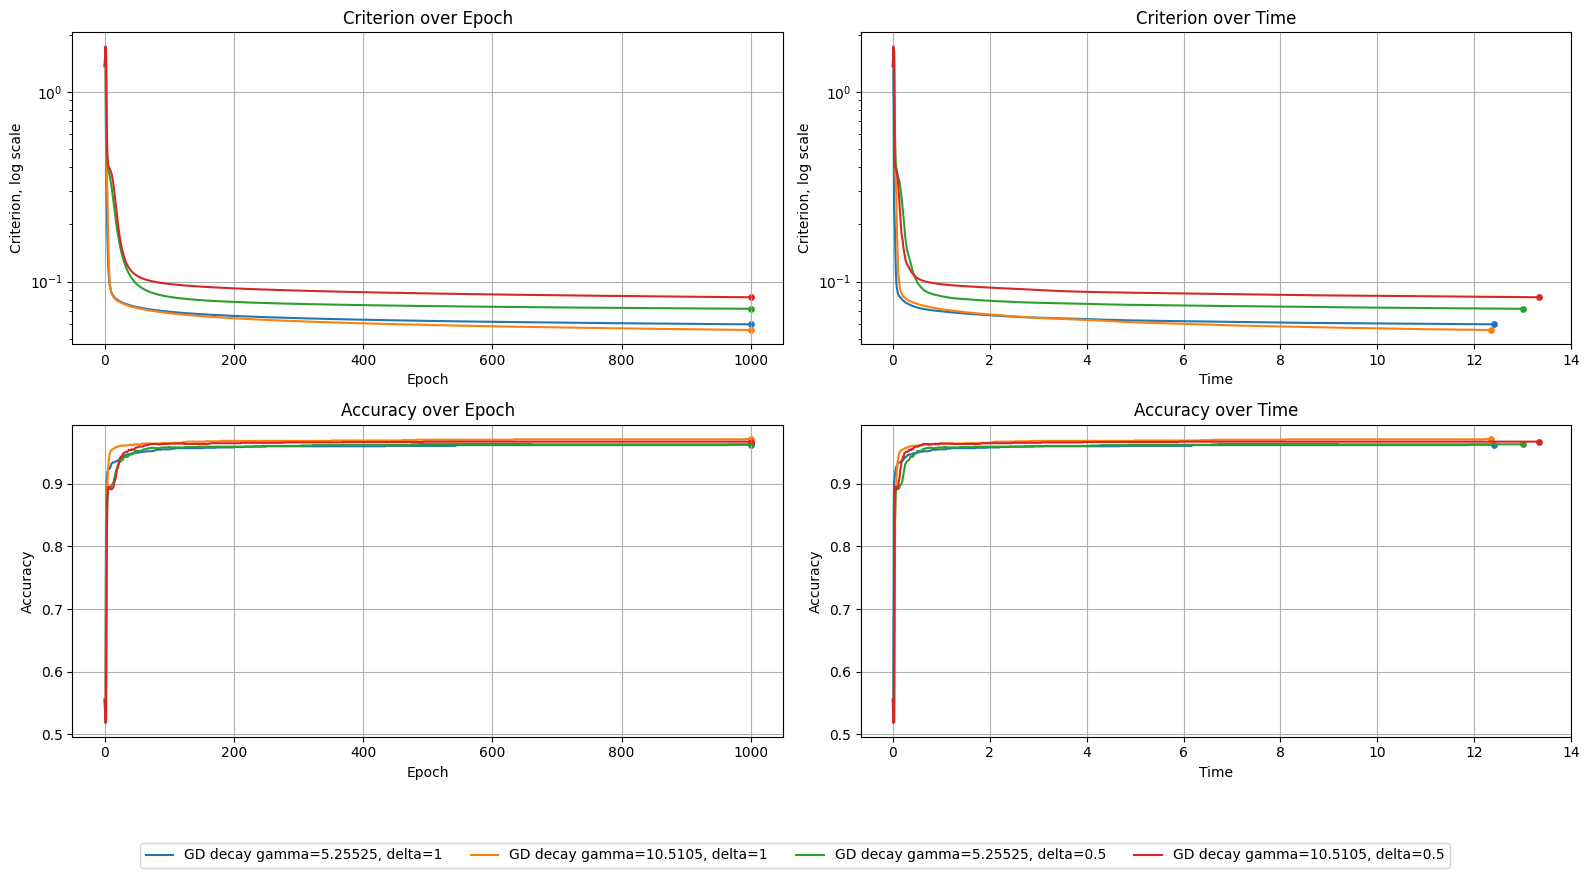

In [ ]:
class GradientDescentDecay(ManualSolver):
    def __init__(self, gamma: float, delta: float, grad_f: Callable = mush_grad, hess_f: Callable = mush_hess) -> None:
        ...

    def step(self, w: np.ndarray, k: int) -> np.ndarray:
        ...

GD sqrt decay gamma=10.5105, delta=0.5: 100%|██████████| 1000/1000 [00:13<00:00, 74.09it/s, Loss=0.113, Accuracy=0.989, Grad norm=0.00137]


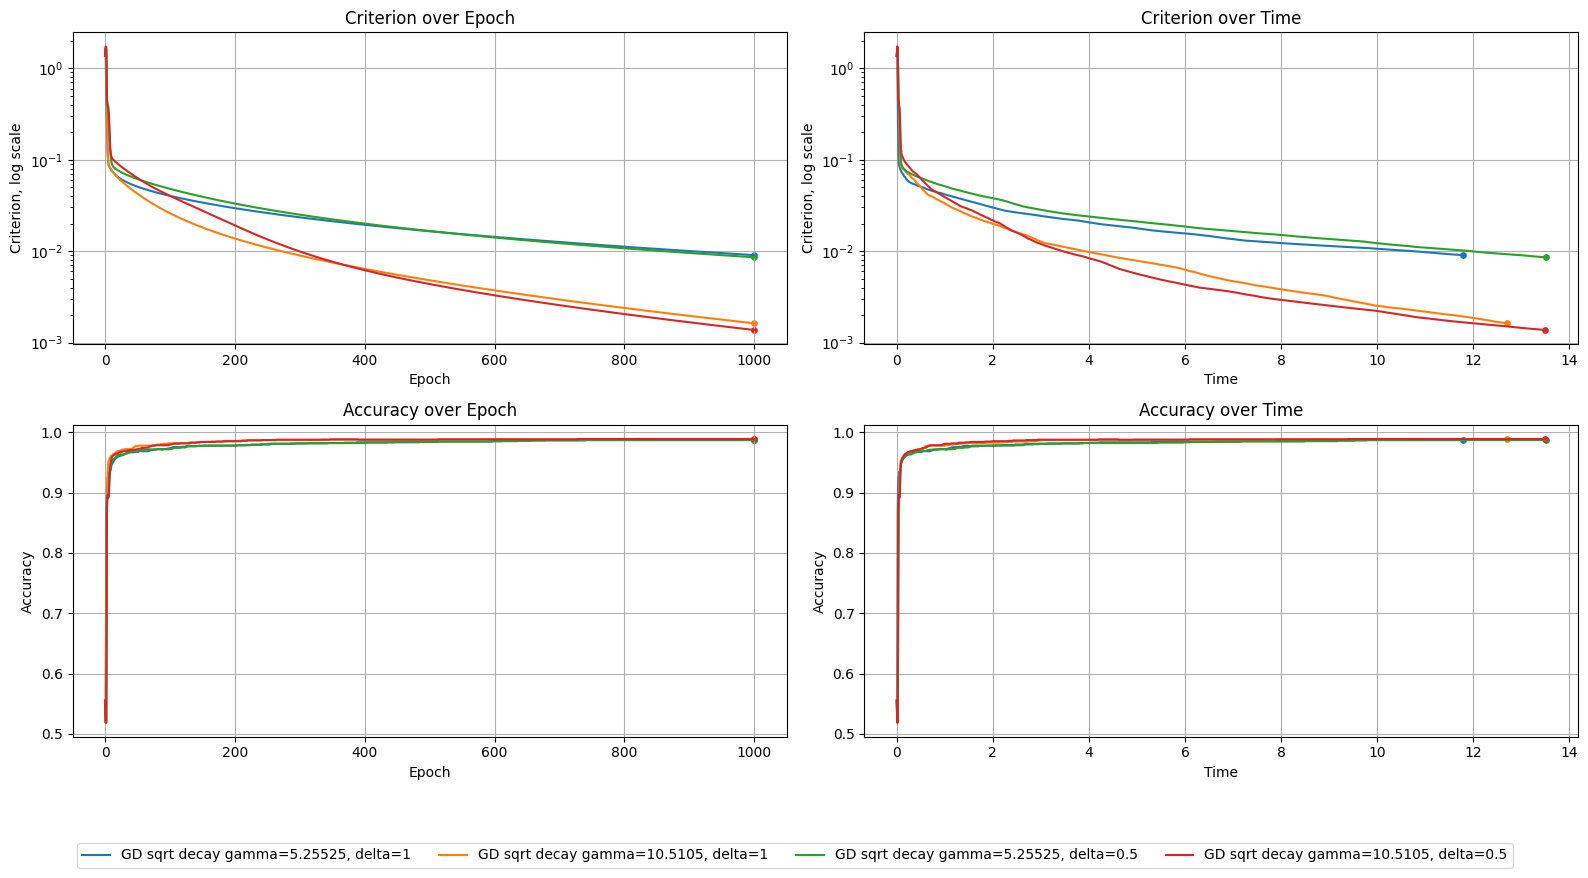

In [ ]:
class GradientDescentSqrtDecay(ManualSolver):
    def __init__(self, gamma: float, delta: float, grad_f: Callable = mush_grad, hess_f: Callable = mush_hess) -> None:
        super().__init__(lr = gamma / delta, grad_f=grad_f, hess_f=hess_f)
        self.gamma = gamma
        self.delta = delta

    def step(self, w: np.ndarray, k: int) -> np.ndarray:
        ...

### Задание 6 (5 баллов)

Рассмотрим так называемый Метод тяжёлого шарика (Heavy Ball)

$$
\begin{align*}
& x_{k+1} = x_k - \gamma_k \sum_{i\in \mathcal{X}} \nabla f_i(x_k) + \beta_k (x_k - x_{k-1})
\end{align*}
$$

Или, как обычно записывают на практике:

$$
\begin{align*}
& h_k = \beta_k h_{k-1} - \gamma_k \sum_{i\in \mathcal{X}} \nabla f_i(x_k) \\
& x_{k+1} = x_k + h_k
\end{align*}
$$

Метод как бы предполагает наличие у текущей точки есть инерция, как у "тяжелого" материального шарика движущегося по наклонной поверхности.


В этом задании вам нужно:
- Реализовать метод тяжёлого шарика как класс, унаследованный от `BaseSolver`. Обратите внимание, что в методе есть дополнительный гиперпараметр $\beta_k$
- Запустить метод тяжёлого шарика на датасете mushrooms на 500 эпохах и подберите лучший набор гиперпарамеров ($\gamma_k$ и $\beta_k$), как выше с градиентным спуском
- Построить графики, как в предыдущем задании
- Сделать выводы. В том числе опишите, на что влияет изменение $\beta_k$

### Решение

Heavy Ball gamma=0.5708577137148565, beta=0.9:  40%|███▉      | 199/500 [00:03<00:04, 66.11it/s, Loss=0.113, Accuracy=0.989, Grad norm=8.24e-6]


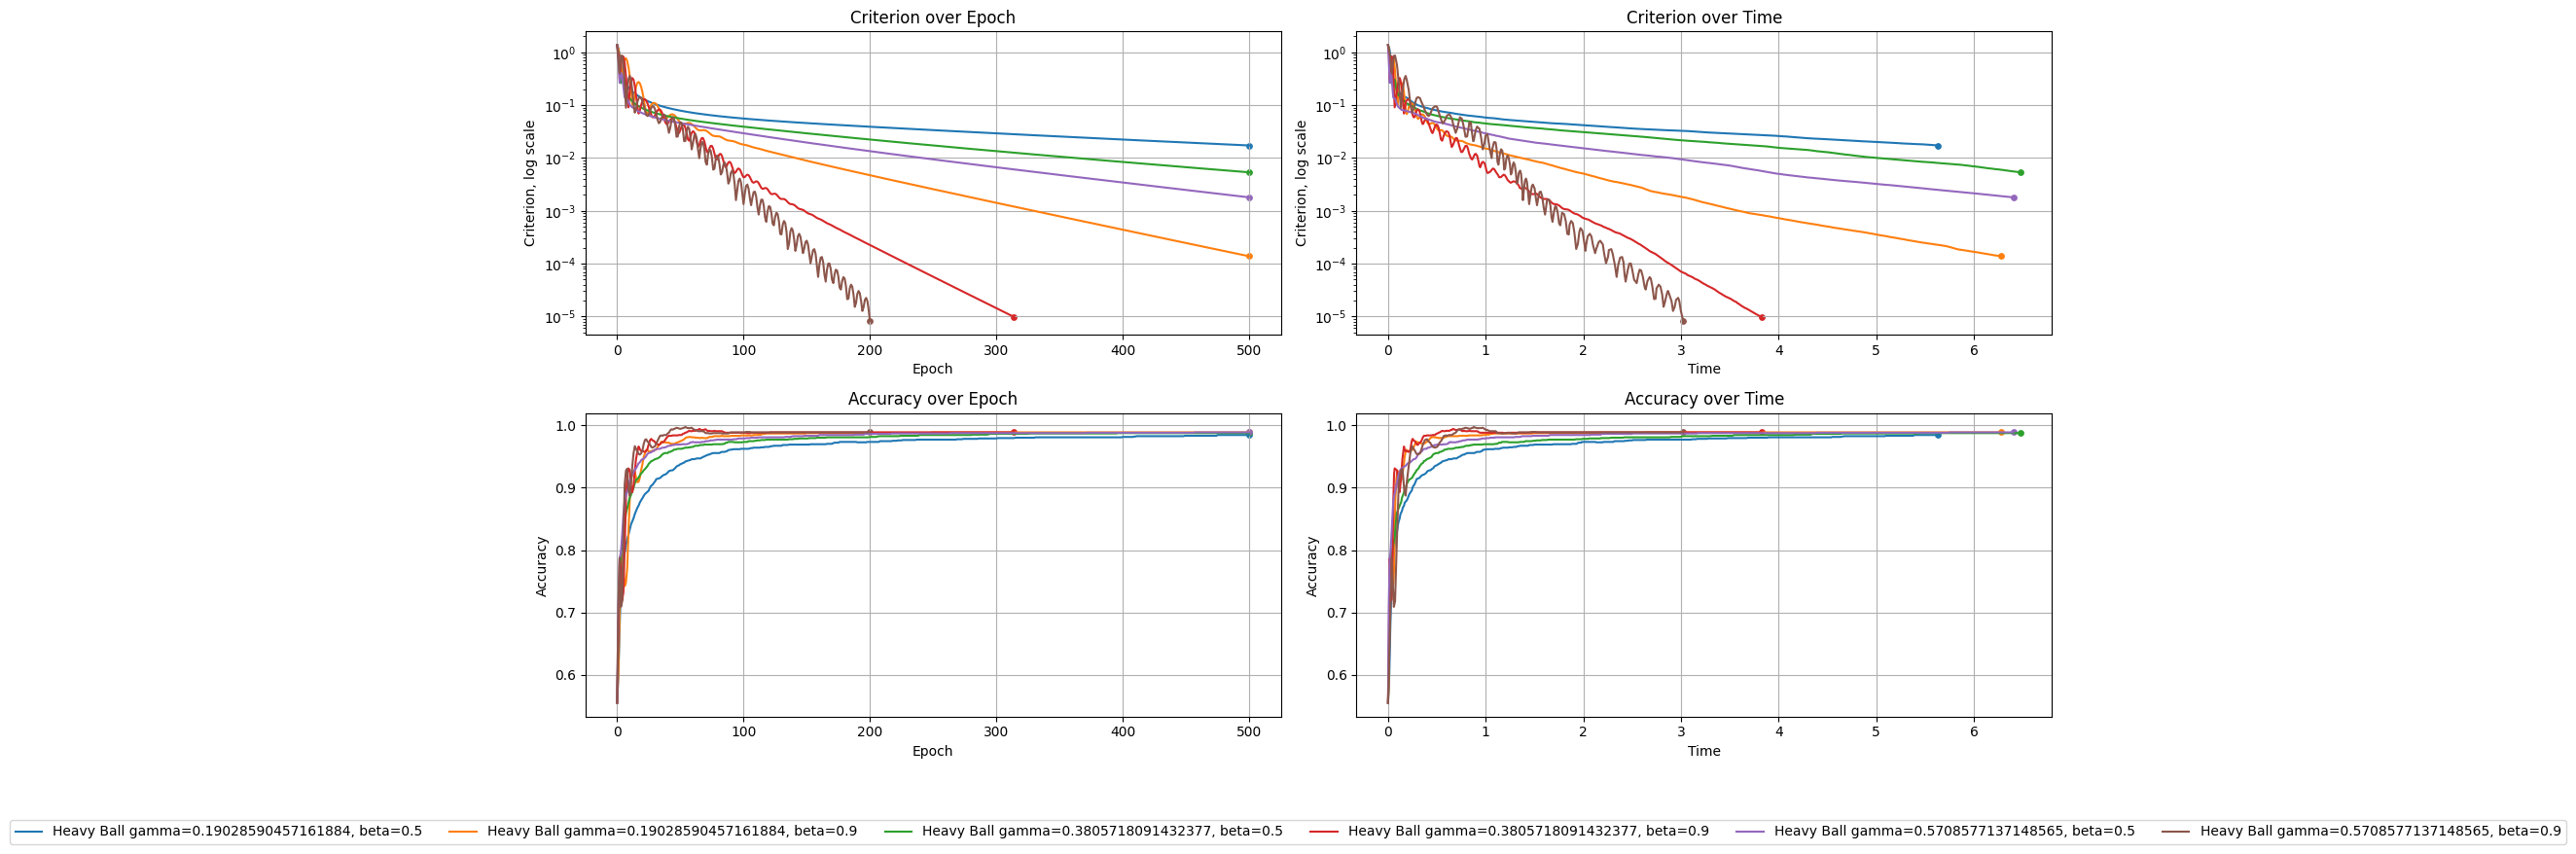

In [ ]:
# ваше решение (code + markdown)

**Выводы**

### Задание 7* (5 баллов)

Рассмотрим ещё один ускоренный метод - Ускоренный градиентный метод Нестерова (Nesterov Momentum)

$$
\begin{align*}
& x_{k+1} = y_k - \gamma_k \sum_{i\in \mathcal{X}} \nabla f_i(y_k) \\
& y_{k+1} = x_{k+1} + \beta_k (x_{k+1} - x_k)
\end{align*}
$$

Или, как обычно записывают на практике:

$$
\begin{align*}
& h_k = \beta_k h_{k-1} - \gamma_k \sum_{i\in \mathcal{X}} \nabla f_i(x_k + \beta_k  h_{k-1})\\
& x_{k+1} = x_k + h_k
\end{align*}
$$

Ключевое отличие метода Нестерова от метода тяжёлого шарика в том, что благодаря импульсу в точку подсчёта градиента, происходит экстраполяция, или "взгляд в будущее"


В этом задании вам нужно:
- Реализовать метод Нестерова как класс, унаследованный от `BaseSolver`
- Запустить метод Нестерова на датасете mushrooms на 500 эпохах и подберите лучший набор гиперпарамеров ($\gamma_k$ и $\beta_k$), как в предыдущих заданиях
- Построить графики, как в предыдущих заданиях
- Сделать выводы. В том числе опишите, на что влияет изменение $\beta_k$

### Решение

Nesterov gamma=0.5708577137148565, beta=0.9:  40%|███▉      | 199/500 [00:02<00:03, 76.47it/s, Loss=0.113, Accuracy=0.989, Grad norm=8.24e-6]


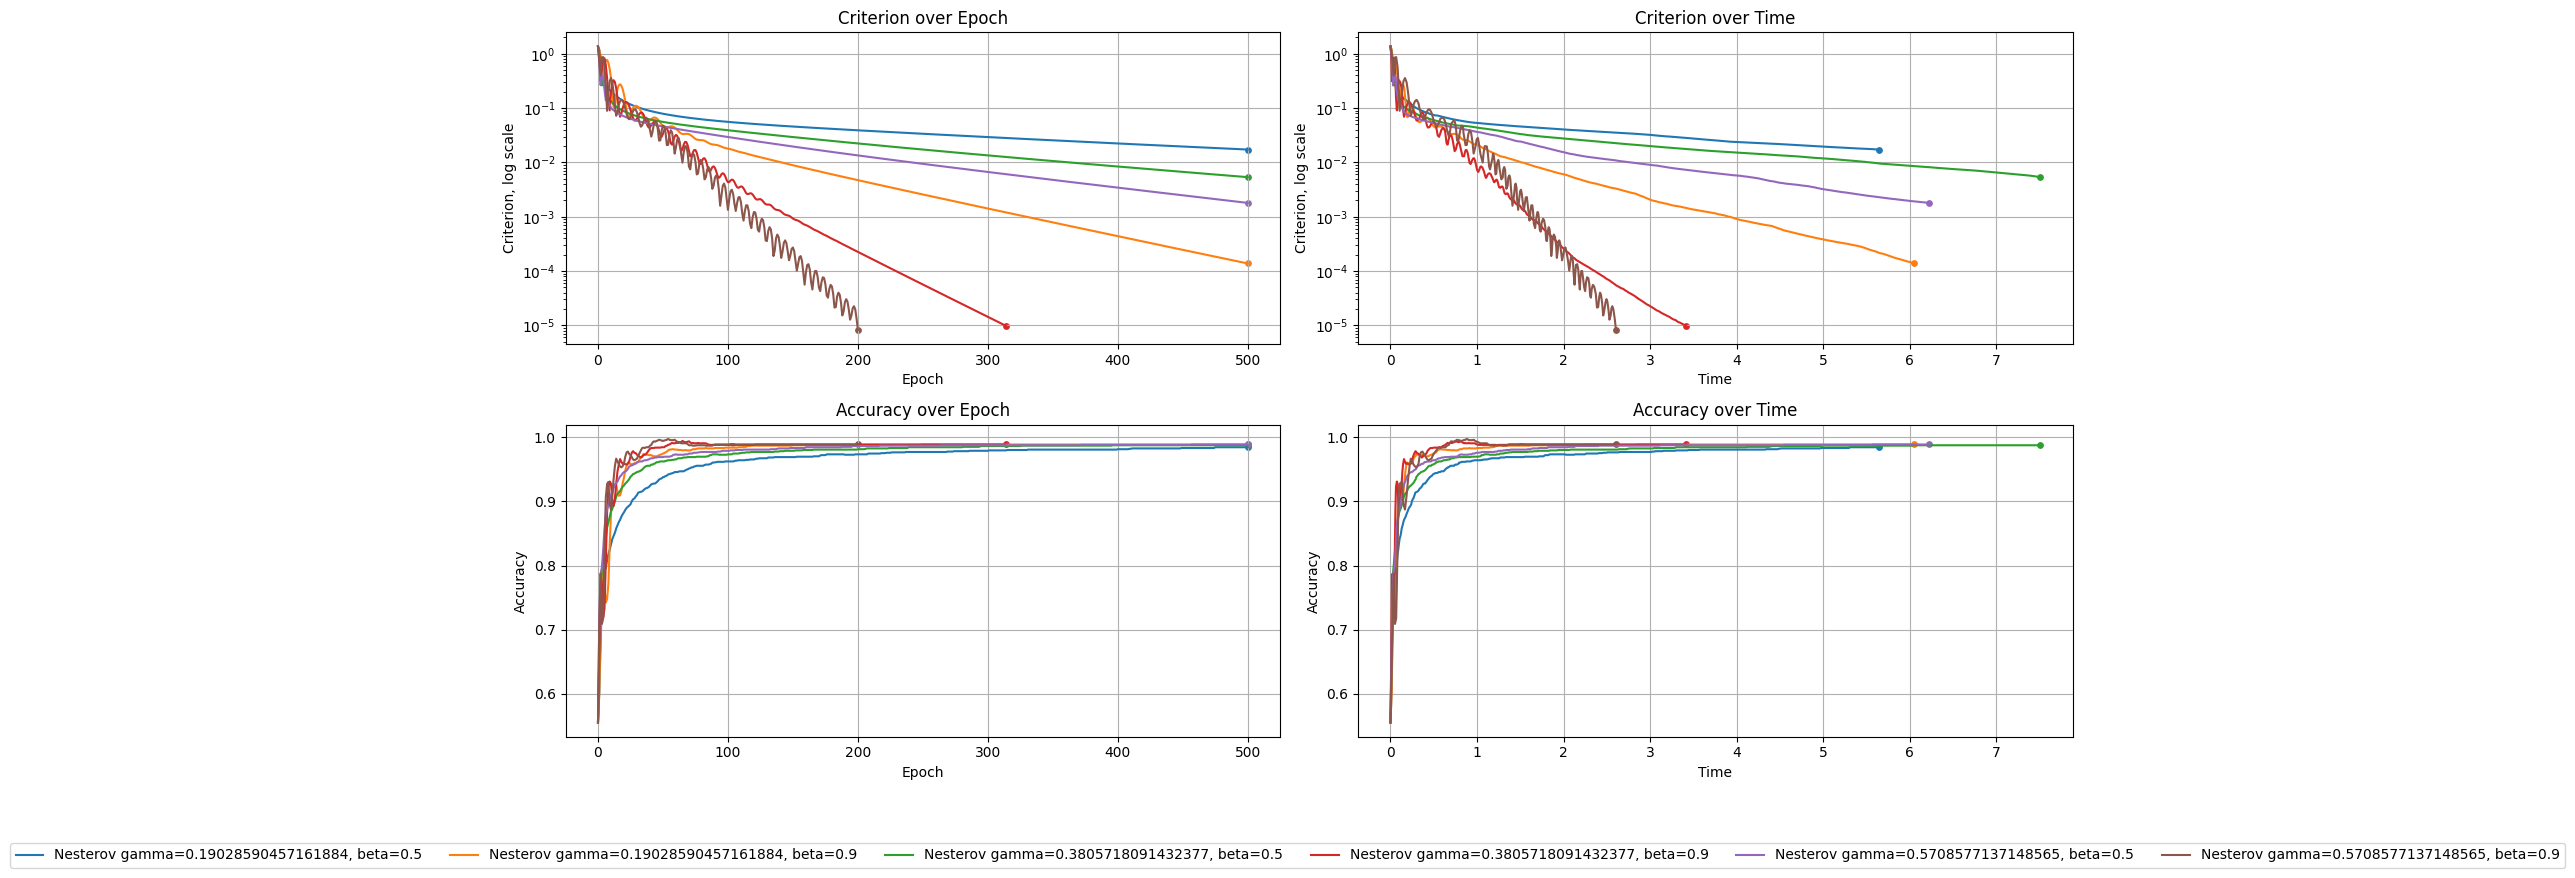

In [ ]:
# ваше решение (code + markdown)

Кажется что лучший Нестеров каждый раз перелетает минимум, хотя очень хорошо сходится

### Задание 8 (5 баллов)

Три предыдущих метода (градиентный спуск, метод тяжёлого шарика и метод Нестерова) относятся к методам первого порядка, так как использует для обновления только градиент целевой функции

Рассмотрим один из самых известных методов второго порядка - Метод Ньютона (Newton's method):

$$
x_{k+1} = x_k - \nabla^2f(x_k)^{-1} \nabla f(x_k)
$$

А точнее, его модификацию - демпфированный метод Ньютона (Dumped Newton's method):

$$
x_{k+1} = x_k - \gamma_k \nabla^2f(x_k)^{-1} \nabla f(x_k)
$$

Как видно из описания метода, для обновления параметров используется обратный гессиан

В этом задании вам нужно:
- Реализовать демпфированный метод Ньютона как класс, унаследованный от `BaseSolver`
- Запустить демпфированный метод Ньютонана датасете mushrooms на 500 эпохах и подберите лучший шаг ($\gamma_k$), как в предыдущих заданиях. Обязательно попробуйте $\gamma_k = 1$, что соответствует оригинальному методу Ньютона
- Построить графики, как в предыдущих заданиях
- Зафиксировать $\gamma_k = 1$ и попробовать варьировать начальную точку алгоритма `start_w`. Обязательно попробуйте нулевой и единичный вектора. Построить графики сходимости
- Сделать выводы

### Решение

Newton gamma=1:   1%|          | 3/300 [00:01<02:11,  2.26it/s, Loss=106, Accuracy=0.523, Grad norm=1.92]<ipython-input-162-751db80220ab>:7: RuntimeWarning: overflow encountered in exp
  log_likelihood = np.log(1 + np.exp(-z))
<ipython-input-162-751db80220ab>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
Newton gamma=$2 / L$:   8%|▊         | 24/300 [00:13<02:30,  1.83it/s, Loss=0.113, Accuracy=0.989, Grad norm=6.29e-6]


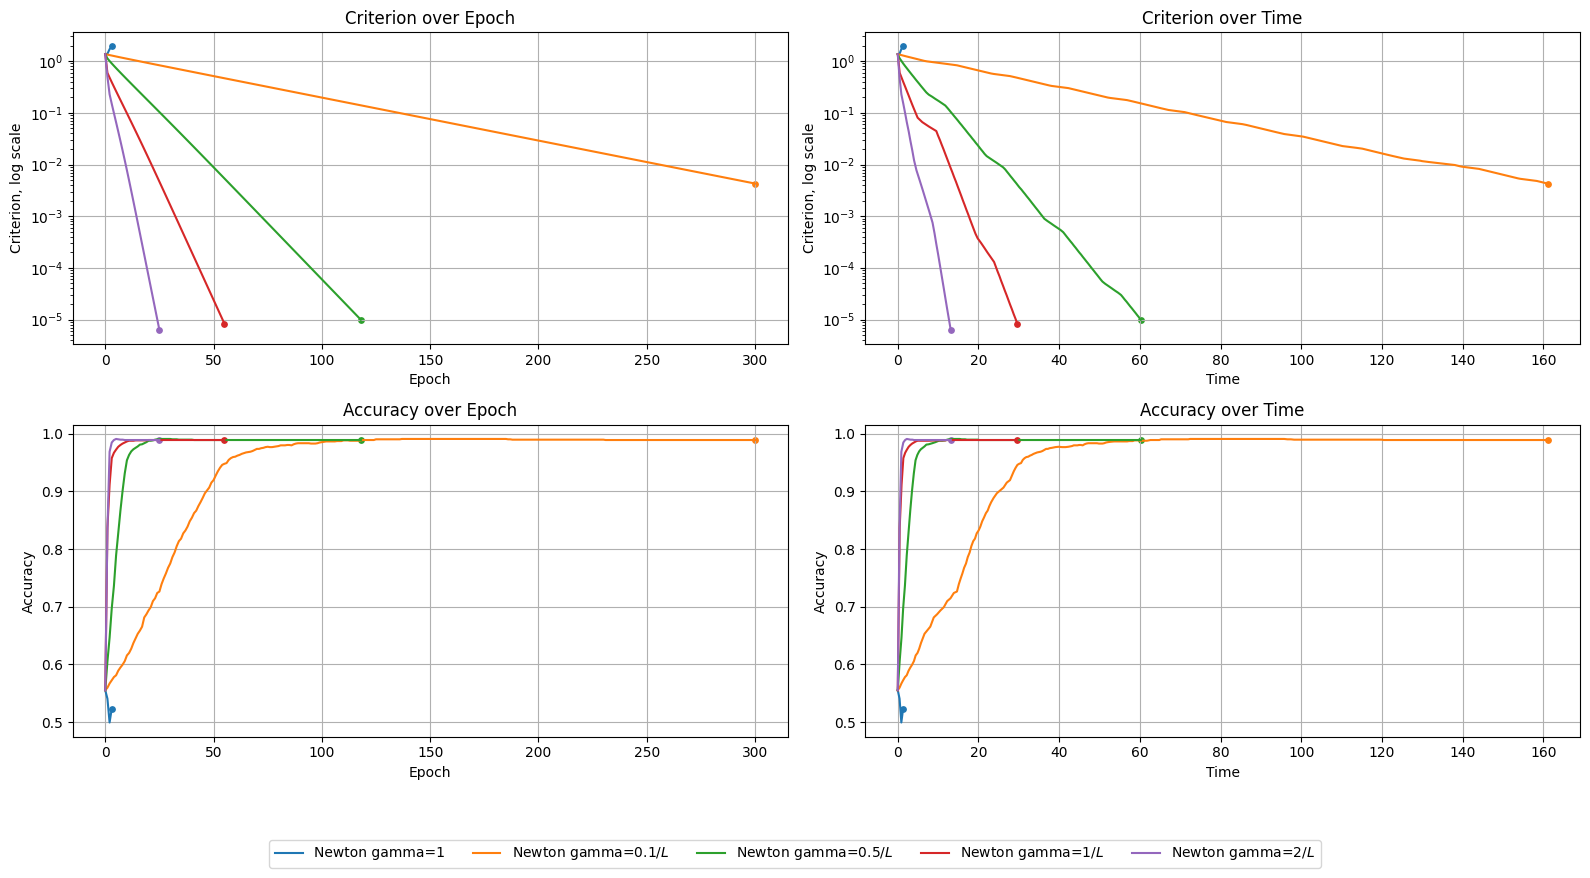

In [ ]:
# ваше решение (code + markdown)

**Выводы**

### Квазиньютоновские методы (BFGS) (7 баллов)

перед сдачей перечитать https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%91%D1%80%D0%BE%D0%B9%D0%B4%D0%B5%D0%BD%D0%B0_%E2%80%94_%D0%A4%D0%BB%D0%B5%D1%82%D1%87%D0%B5%D1%80%D0%B0_%E2%80%94_%D0%93%D0%BE%D0%BB%D1%8C%D0%B4%D1%84%D0%B0%D1%80%D0%B1%D0%B0_%E2%80%94_%D0%A8%D0%B0%D0%BD%D0%BD%D0%BE

дано $ɛ, x_0$

инициализировать $C_0$

$k=0$

while $||\nabla f_k|| > ɛ$

$\quad$ найти направление $p_k=-C_k \nabla f_k$

$\quad$ вычислить $x_k+1 = x_k +a_k p_k$, $a_k$ удовлетворяет условиям Вольфе (в коде не проверяется)

$\quad$ обозначить $s_k = x_{k+1} - x_k$ и $y_k = \nabla f_{k+1} - \nabla f_k$

 $\quad$ вычислить $C_{k+1}=(I-\rho _{k}s_{k}y_{k}^{T})C_{k}(I-\rho _{k}y_{k}s_{k}^{T})+\rho _{k}s_{k}s_{k}^{T},$

 $\quad k = k+1$

BFGS gamma=$30 / L$: 100%|██████████| 1000/1000 [00:16<00:00, 59.25it/s, Loss=0.347, Accuracy=0.973, Grad norm=0.06]


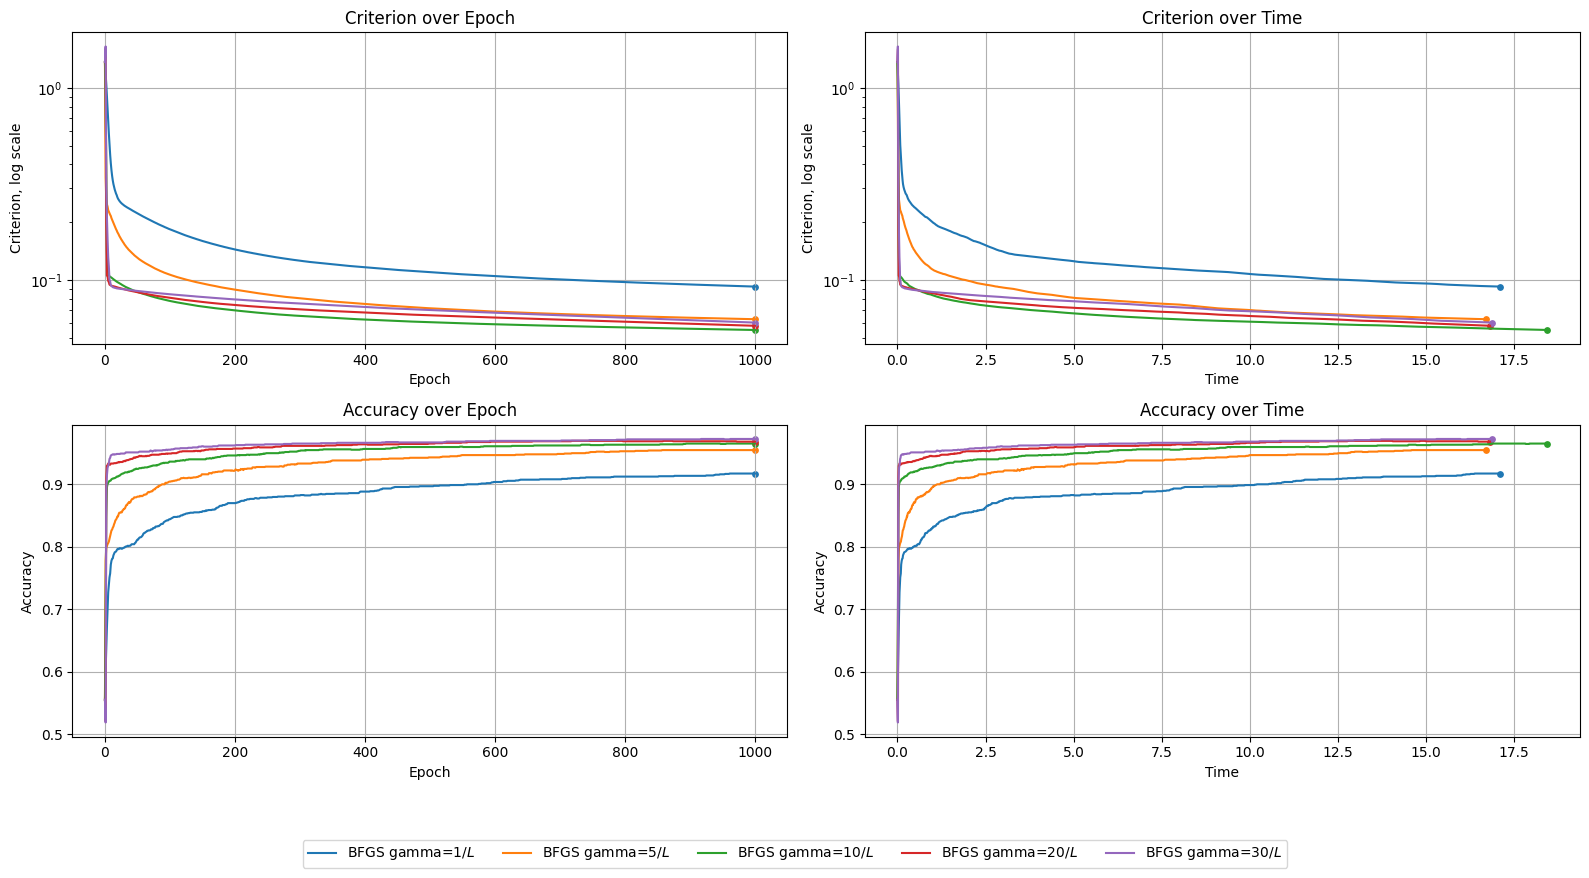

In [ ]:
# ваше решение (code + markdown)

### Задание 9 (2 балла)

В этом задании вам нужно:
- Построить общий график для лучших методов из предыдущих заданий (градиентный спуск, метод тяжёлого шарика, метод Нестерова*, метод Ньютона)
- Объяснить, по каким критериям выбирали лучшие методы
- Сделать выводы. Какой метод наиболее предпочтителен? Почему?

### Решение

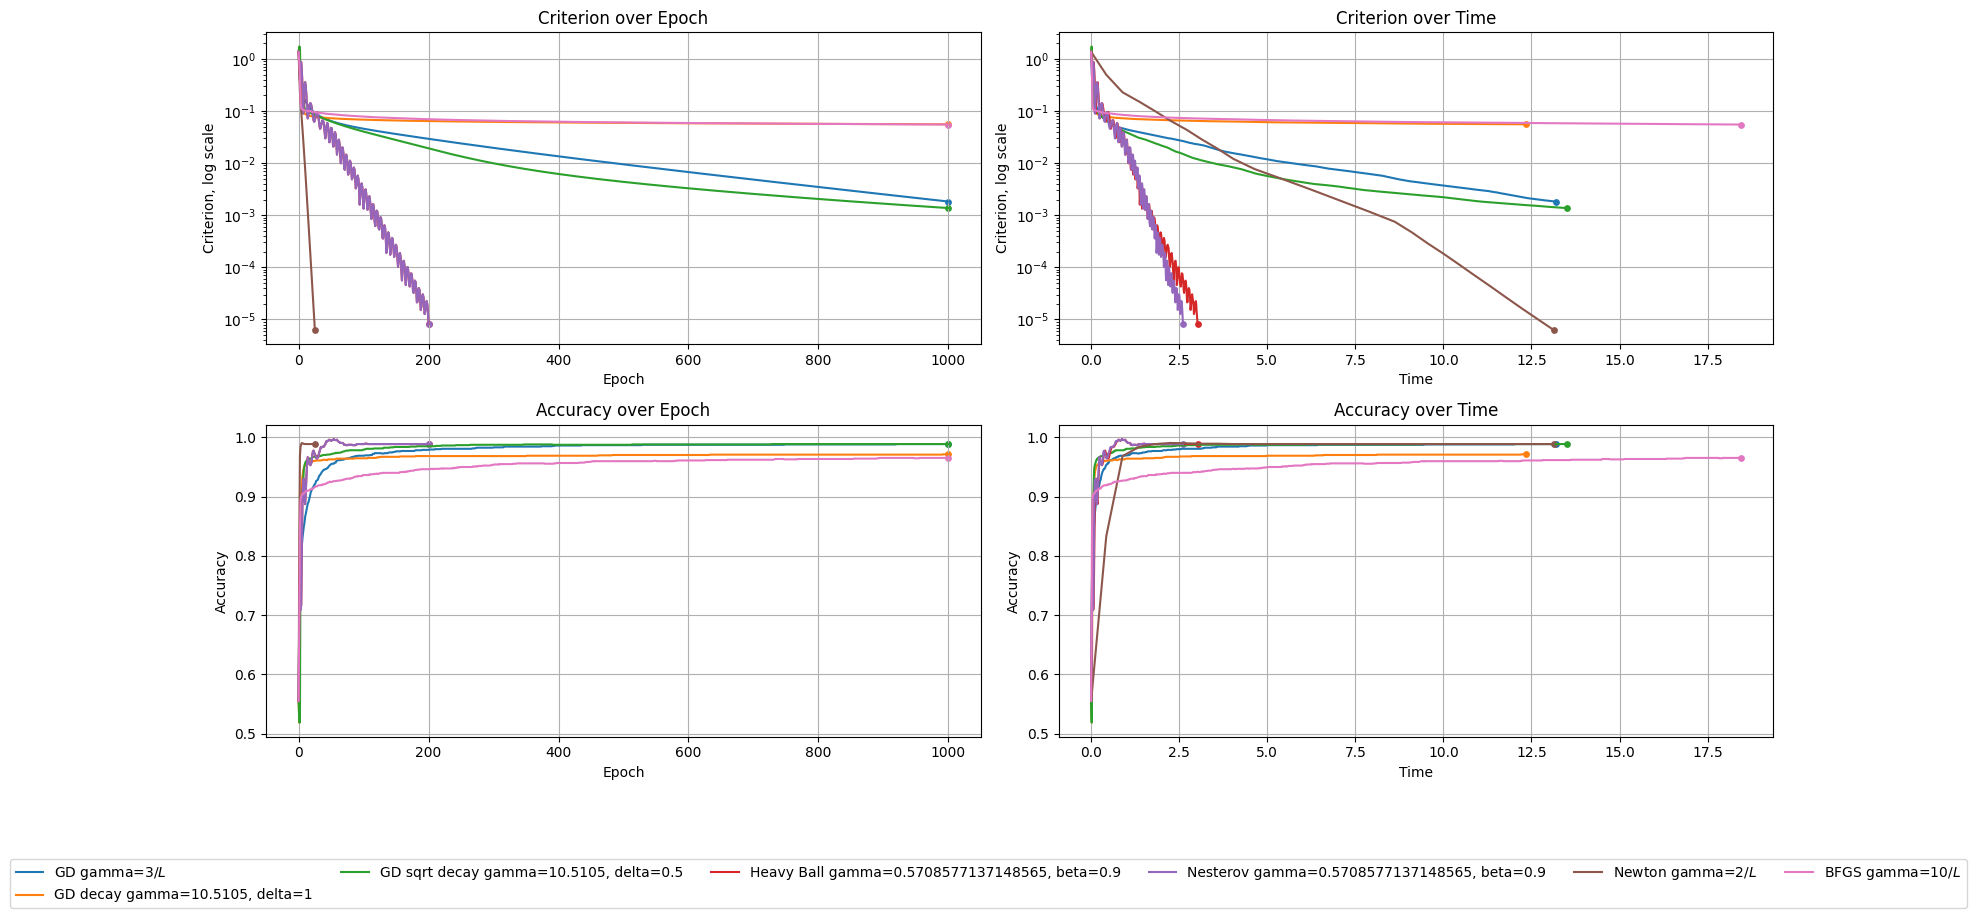

In [ ]:
# ваше решение (code + markdown)

**Выводы**
